In [1]:
import matplotlib.pyplot as plt
import numpy as np
import types # used to re-define acceleration / force

from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

# Chapter 2: Kinematics

In [2]:
class TimeValue:
    def __init__(self, time, value):
        self.time = time * 1.0
        self.value = value * 1.0

    def __repr__(self):
        return '({}, {})'.format(self.time, self.value)

In [80]:
class TimeSeries:
    def __init__(self, points=[]):
        self.series = []
        for (time, value) in points:
            self.append(time, value)
        
    def append(self, time, value):
        self.series.append(TimeValue(time, value))
        self.series = sorted(self.series, key=lambda x: x.time)
        
    @property
    def initial(self):
        return self.series[0]
    
    @property
    def timeline(self):
        return [x.time for x in self.series]
    
    @property
    def values(self):
        return [x.value for x in self.series]
    
    @property
    def components(self, i=None):
        try:
            return list(zip(*self.values))
        except:
            return [self.values]

    def plot(self, toggle='0', title='', legend_loc='best', grid=True, marker=None, labels=None):
        if len(self.components) > 1:
            plt.plot(self.timeline, self.values, marker=marker)
            if legend_loc:
                plt.legend(['x','y','z'][:len(self.components)], loc=legend_loc, numpoints=1)
        else:
            r = self
            v = r.rate_of_change()
            a = v.rate_of_change()
            
            if '0' in toggle:
                plt.plot(r.timeline, r.values, marker=marker, label='position')
            if '1' in toggle:
                plt.plot(v.timeline, v.values, marker=marker, label='velocity')
            if '2' in toggle:
                plt.plot(a.timeline, a.values, marker=marker, label='acceleration')
            if legend_loc:
                if labels:
                    plt.legend(labels, loc=legend_loc, numpoints=1)
                else:
                    plt.legend(loc=legend_loc, numpoints=1)
        plt.title(title)
        plt.xlabel('Time')
        plt.margins(0.05)
        dt = 0.03 * (self.timeline[-1] - self.timeline[0])
        plt.axes().set_xlim([self.timeline[0] - dt, self.timeline[-1] + dt])
        if grid:
            plt.axes().axhline(0, c='gray', lw=0.5)
            plt.grid(True)

        
    def plot2d(self, x_index=0, y_index=1, toggle='012', title='',
               grid=True, legend_loc='lower left', tocks=True, arrows=True):
        
        r = self
        rx = r.components[x_index]
        ry = r.components[y_index]

        v = r.rate_of_change()
        vx = v.components[x_index]
        vy = v.components[y_index]

        a = v.rate_of_change()
        ax = a.components[x_index]
        ay = a.components[y_index]
        
        r_color, v_color, a_color = 'bgr'
        nmark = int(len(rx)/10)

        if '0' in toggle:
            plt.plot(rx, ry, c=r_color, label='position', 
                     markevery=[-1], marker='o', mfc='w', mec=r_color, mew=1)
            if tocks:
                plt.plot(rx, ry, lw=0, markevery=nmark, marker='.', mec=r_color)

        if '1' in toggle:
            plt.plot(vx, vy, c=v_color, label='velocity',
                     markevery=[-1], marker='o', mfc='w', mec=v_color, mew=1)            
            if tocks:
                plt.plot(vx, vy, lw=0, markevery=nmark, marker='.', mec=v_color)

        if '2' in toggle:
            plt.plot(ax, ay, c=a_color, label='acceleration', 
                     markevery=[-1], marker='o', mfc='w', mec=a_color, mew=1)
            if tocks:
                plt.plot(ax, ay, lw=0, markevery=nmark, marker='.', mec=a_color)
            
        plt.axes().set_aspect('equal')
        plt.margins(0.05)
        if legend_loc:
            plt.legend(numpoints=1, loc=legend_loc)
        plt.title(title)
        
        if grid:
            plt.axes().axhline(0, c='k')
            plt.axes().axvline(0, c='k')
            plt.grid(True)

        if arrows:
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            size = 0.5 * (xmax - xmin) + 0.5 * (ymax - ymin)
            head_size = {
                'head_width': 0.03 * size,
                'head_length': 0.05 * size,
            }
            if '1' in toggle:
                plt.axes().arrow(rx[-1], ry[-1], vx[-1], vy[-1], fc=v_color, ec=v_color, **head_size)
            if '2' in toggle:
                plt.axes().arrow(rx[-1], ry[-1], ax[-1], ay[-1], fc=a_color, ec=a_color, **head_size)
             
    @property
    def intervals(self):
        intervals = []
        for i in range(1, len(self.series)):
            intervals.append((self.series[i - 1], self.series[i]))
        return intervals    
 
    def get_interval(self, time): # closed on left [a, b)
        tmin = min(self.timeline)
        tmax = max(self.timeline)
        if time < tmin:
            return None, self.series[0]
        elif time >= tmax:
            return self.series[-1], None
        else:
            for a, b in self.intervals:
                if a.time <= time and time < b.time:
                    return a, b
    
    def rate_of_change(self):
        ts = TimeSeries()
        for i, (a, b) in enumerate(self.intervals):
            dx = b.value - a.value
            dt = b.time - a.time
            if 1 == 0:
                ts.append(a.time, dx/dt)
            else:
                ts.append(a.time + dt/2, dx/dt)
        return ts
                
    def __call__(self, time):
        a, b = self.get_interval(time)
        # this method will not extrapolate, but we do need to take care of this edge case...
        if b is None and round(a.time - time, 10) == 0:
            return a.value
        else:
            dx = b.value - a.value
            dt = b.time - a.time
            return a.value + dx/dt * (time - a.time)
        
    def __repr__(self):
        import pprint
        return pprint.pformat(self.series)


**Free fall motion (no air drag)**

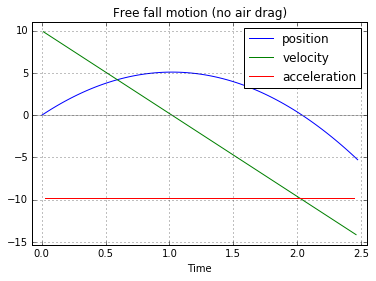

In [81]:
y = TimeSeries()
for i in range(100):
    t = i/40
    y.append(t, 10*t-4.9*t**2)
y.plot(title='Free fall motion (no air drag)',toggle='012')

**Uniform circular motion**

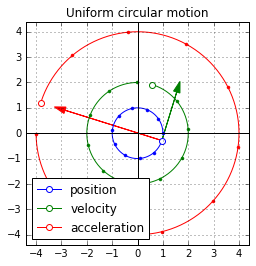

In [82]:
r = TimeSeries()
for q in range(600):
    t = q / 100
    x = 1.0 * np.cos(t)
    y = 1.0 * np.sin(t)
    r.append(0.5 * t, np.array([x,y]))
r.plot2d(title='Uniform circular motion')

**The components of UCM are SHM**

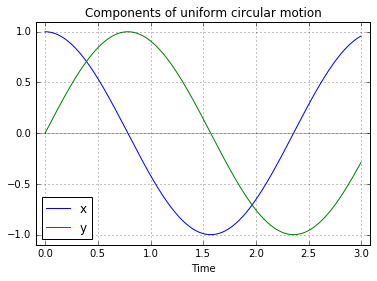

In [83]:
r.plot(title='Components of uniform circular motion')

# Chapter 4: Dynamics

In [237]:
class RigidObject():
    def __init__(self, mass=1, t0=0, r0=0, p0=0):
        self.mass = mass
        self.position = TimeSeries([(t0, r0)])
        self.momentum = TimeSeries([(t0, p0)])

    def netforce(self, time): # momentum flow or rate of change
        return 0

    def velocity(self, time): # position flow or rate of change
        return self.momentum(time) / self.mass
    
    def increment(self, dt):
        t = max(self.position.timeline)

#         if len(self.position.timeline) == 1: # then go forward only 1/2 an increment
#             t = self.position.initial.time
#             next_r = self.position.initial.value + self.velocity(t) * dt/2
#             next_p = self.momentum.initial.value + self.netforce(t) * dt/2
#             self.position.append(t + dt/2, next_r)
#             self.momentum.append(t + dt/2, next_p)
#         else:
#             t = max(self.position.timeline)

#             t = t + dt/2
#             next_r = self.position(t - dt) + self.velocity(t - dt/2) * dt
#             next_p = self.momentum(t - dt/2) + self.netforce(t - dt/2) * dt/2
#             self.position.append(t, next_r)
#             self.momentum.append(t, next_p)

#             t = t + dt/2
#             next_r = self.position(t - dt/2) + self.velocity(t - dt/2) * dt/2
#             next_p = self.momentum(t - dt) + self.netforce(t - dt/2) * dt
#             self.position.append(t, next_r)
#             self.momentum.append(t, next_p)

            

        if len(self.momentum.timeline) == 1: # then go forward only 1/2 an increment
            t = self.momentum.initial.time
            next_p = self.momentum.initial.value + self.netforce(t) * dt/2
#            self.momentum = TimeSeries()
            self.momentum.append(t + dt/2, next_p)
        else:
            t = max(self.position.timeline)

            t = t + dt
            next_r = self.position(t - dt) + self.velocity(t - dt/2) * dt
            self.position.append(t, next_r)
            
            t = t + dt/2
            next_p = self.momentum(t - dt) + self.netforce(t - dt/2) * dt
            self.momentum.append(t, next_p)

            
            
            
            
#         if len(self.position.timeline) == 1:  
            
#             # need to "offset" the initial position to make the rate_of_change
#             # calculations work properly at the beginning
            
#             t = self.position.initial.time
#             v0 = self.momentum.initial.value / self.mass
#             r0 = self.position.initial.value - v0 * dt/2
#             self.position = TimeSeries()
#             self.position.append(t - dt/2, r0)
                        
#             next_r = self.position.initial.value + self.velocity(t) * dt
#             next_p = self.momentum.initial.value + self.netforce(t) * dt/2
#             self.position.append(t + dt/2, next_r)
#             self.momentum.append(t + dt/2, next_p)
#         else:
#             t = max(self.position.timeline)

#             t = t + dt/2
#             next_p = self.momentum(t - dt/2) + self.netforce(t - dt/2) * dt/2
#             self.momentum.append(t, next_p)

#             t = t + dt/2
#             next_r = self.position(t - dt) + self.velocity(t - dt/2) * dt
#             next_p = self.momentum(t - dt) + self.netforce(t - dt/2) * dt
#             self.position.append(t, next_r)
#             self.momentum.append(t, next_p)

**Details of calculation**

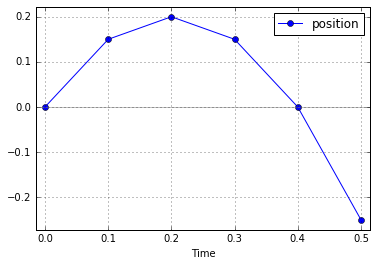

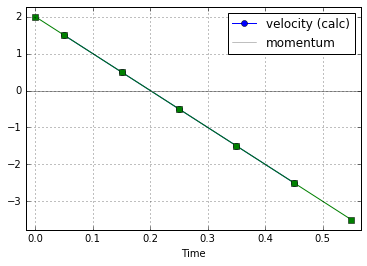

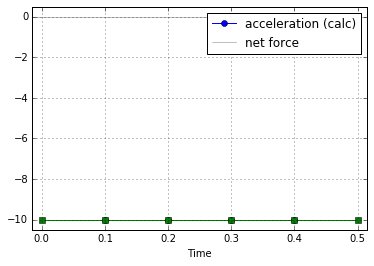

In [238]:
obj = RigidObject(p0=2)
obj.netforce = lambda t: -10
for i in range(6):
    obj.increment(0.1)
obj.position.plot(marker='o')
plt.figure()
obj.position.plot(toggle='1', marker='o')
obj.momentum.plot(marker='s')
plt.legend(['velocity (calc)','momentum'], numpoints=1)
plt.figure()
obj.position.plot(toggle='2', marker='o')
plt.plot(obj.position.timeline, [obj.netforce(t) for t in obj.position.timeline], marker='s')
plt.legend(['acceleration (calc)','net force'], numpoints=1)

**Damped Harmonic Motion**

In [137]:
obj = RigidObject(p0=60)
obj.netforce = lambda t: -obj.position(t) - 0.5 * obj.velocity(t)
for i in range(200):
    obj.increment(0.1)
obj.position.plot('012', title='Damped Harmonic Motion')

AttributeError: 'NoneType' object has no attribute 'value'